In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'sample_submission.csv', 'train.csv', 'train']


In [2]:
from tqdm import tqdm

path = '../input'
train_csv = os.path.join(path, 'train.csv')
train = pd.read_csv(train_csv)
print(train.head())
categories = train.groupby('Id').size()

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale


In [3]:
# Make Categories dictionary
Id_dict = {}

for i, id in enumerate(categories.index):
    if id in Id_dict:
        continue
    Id_dict[id] = i

print('Number of categories of Whale: {}'.format(len(Id_dict)))

Id_to_num = []
for id in tqdm(train.Id):
    Id_to_num.append(Id_dict[id])

100%|██████████| 25361/25361 [00:00<00:00, 1510533.14it/s]

Number of categories of Whale: 5005


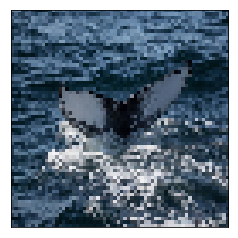

In [4]:
import cv2
import matplotlib.pyplot as plt

def read_images(image_name):
    base_size = 64
    path = '../input/train'
    image_path = os.path.join(path, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (base_size, base_size))
    
    return img
    
#For test
img = read_images('0000e88ab.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

In [5]:
img_data = []

for img_name in tqdm(train.Image):
    img = read_images(img_name)
    img_data.append(img)

print(len(img_data))
train['Image_Data'] = img_data
train['Id_to_num'] = Id_to_num

100%|██████████| 25361/25361 [03:14<00:00, 130.26it/s]

25361


In [6]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

train_data, vaild_data = train_test_split(train, test_size=0.1, random_state=2018)
print(train_data.head())
print(vaild_data.head())

X_train, y_train = np.asarray(list(train_data.Image_Data)), train_data.Id_to_num
X_test, y_test = np.asarray(list(vaild_data.Image_Data)), vaild_data.Id_to_num
y_train = to_categorical(y_train, num_classes=len(Id_dict))
y_test = to_categorical(y_test, num_classes=len(Id_dict))

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)


Using TensorFlow backend.


               Image    ...    Id_to_num
10182  670d308f6.jpg    ...         2713
12421  7dadaa49f.jpg    ...         4141
1544   0f6de2175.jpg    ...         2778
9568   60eae9ed2.jpg    ...            0
17749  b20e66aa4.jpg    ...           41

[5 rows x 4 columns]
               Image    ...    Id_to_num
10168  66ee1433e.jpg    ...         1028
10046  65c1c4693.jpg    ...         2435
20004  c96beee45.jpg    ...            0
13351  869137af0.jpg    ...         4038
13158  84b12af51.jpg    ...         3736

[5 rows x 4 columns]
(22824, 5005)
(2537, 5005)
(22824, 64, 64, 3)
(2537, 64, 64, 3)


In [7]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Input, GlobalAvgPool2D, Dense, Dropout
from keras import metrics
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

def top_5_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

model = ResNet50(input_shape=(64, 64, 3),  include_top=True, weights=None, classes=len(Id_dict))
model.compile(optimizer= optimizers.Adam(lr=0.001, decay=0.01),loss='categorical_crossentropy', 
              metrics=[metrics.categorical_accuracy, top_5_accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [EarlyStopping(patience=0),ReduceLROnPlateau(patience=0)]

traingen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
testgen = ImageDataGenerator(rescale=1./255)

In [9]:
model.fit_generator(traingen.flow(X_train, y_train, batch_size=32), steps_per_epoch=X_train.shape[0]/32, epochs=100, 
                   callbacks=callbacks, validation_data=testgen.flow(X_test, y_test, batch_size=32), verbose=1)

Epoch 1/100
714/713 [==============================] - 230s 322ms/step - loss: 9.9795 - categorical_accuracy: 0.3800 - top_5_accuracy: 0.4247 - val_loss: 9.9745 - val_categorical_accuracy: 0.3812 - val_top_5_accuracy: 0.4296
Epoch 2/100
714/713 [==============================] - 211s 296ms/step - loss: 9.9765 - categorical_accuracy: 0.3810 - top_5_accuracy: 0.4260 - val_loss: 9.9745 - val_categorical_accuracy: 0.3812 - val_top_5_accuracy: 0.4277
Epoch 3/100
714/713 [==============================] - 211s 295ms/step - loss: 9.9765 - categorical_accuracy: 0.3810 - top_5_accuracy: 0.4266 - val_loss: 9.9745 - val_categorical_accuracy: 0.3812 - val_top_5_accuracy: 0.4312


In [14]:
test_pictures = os.listdir('../input/test')
print(test_pictures[:5])

def read_test_images(image_name):
    base_size = 64
    path = '../input/test'
    image_path = os.path.join(path, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (base_size, base_size))
    img = img / 255
    
    return img

test_images = []
for img_name in test_pictures:
    test_images.append(read_test_images(img_name))

test_images = np.asarray(test_images)
print(test_images.shape)

['009dd6c96.jpg', '2a73b60f7.jpg', '4d2f1d959.jpg', '0c9dd9352.jpg', 'f6c4f44c5.jpg']
(7960, 64, 64, 3)


In [11]:
def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :5], columns=['a', 'b', 'c', 'd', 'e'])

to_class = {}
for key, value in Id_dict.items():
    to_class[value] = key

all_top5 = pd.DataFrame()
test_predictions = model.predict(test_images, batch_size=128, verbose=1)
top5 = preds2catids(test_predictions)
all_top5 = all_top5.append(top5, ignore_index=True)
print(all_top5.head())

7960/7960 [==============================] - 9s 1ms/step
   a     b     c     d     e
0  0  3064  1051  4981  2159
1  0  3064  1051  4981  3855
2  0  3064  1051  4981  2159
3  0  3064  1051  4981  2159
4  0  3064  1051  4981  2159


In [12]:
all_top5 = all_top5.replace(to_class)
all_top5.head()

,a,b,c,d,e
0,new_whale,w_9d56f22,w_34ecf36,w_fe94155,w_6f7611c
1,new_whale,w_9d56f22,w_34ecf36,w_fe94155,w_c62ca3a
2,new_whale,w_9d56f22,w_34ecf36,w_fe94155,w_6f7611c
3,new_whale,w_9d56f22,w_34ecf36,w_fe94155,w_6f7611c
4,new_whale,w_9d56f22,w_34ecf36,w_fe94155,w_6f7611c


In [13]:
predictions = all_top5['a'] + ' ' + all_top5['b'] + ' ' + all_top5['c'] + ' ' + all_top5['d'] + ' ' + all_top5['e'] 

submission = pd.DataFrame({'Image':test_pictures,
                          'Id': predictions})

submission.head()
submission.to_csv('submission.csv', index=False)

In [17]:
print(os.listdir("../working"))

['.ipynb_checkpoints', '__notebook_source__.ipynb', 'submission.csv']
